<a href="https://colab.research.google.com/github/prajwal-u2/advanced-machine-learning/blob/main/Bayesian_Linear_Regression/Bayesian_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1

# I. Multivariate Gaussians [25 points]

The Multivariate Gaussian (or Normal) distribution is arguably the most important probability distribution in machine learning (bayesian modeling,
generative models, latent-variable models, etc.). This exercise involves understanding multivariate gaussians and its properties.

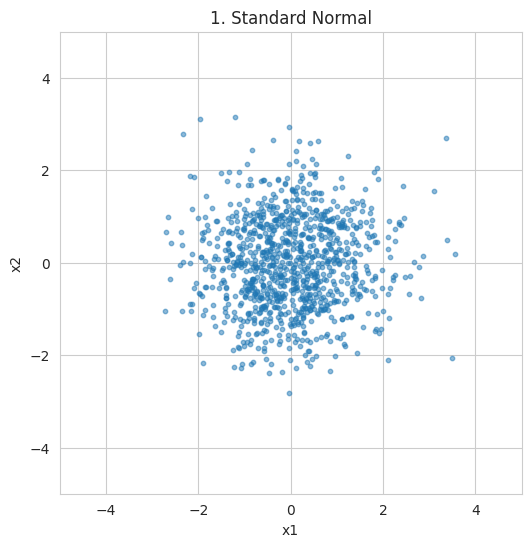

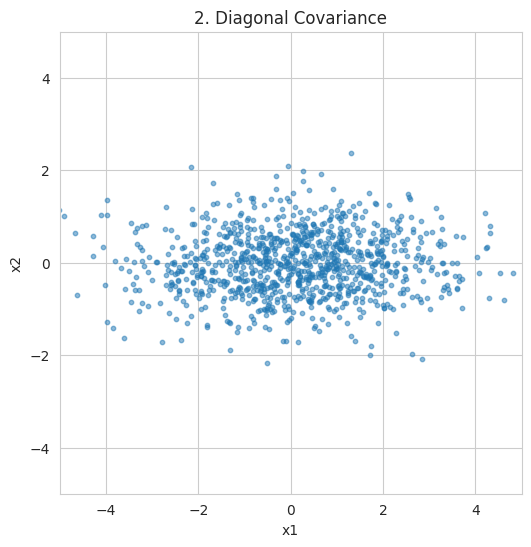

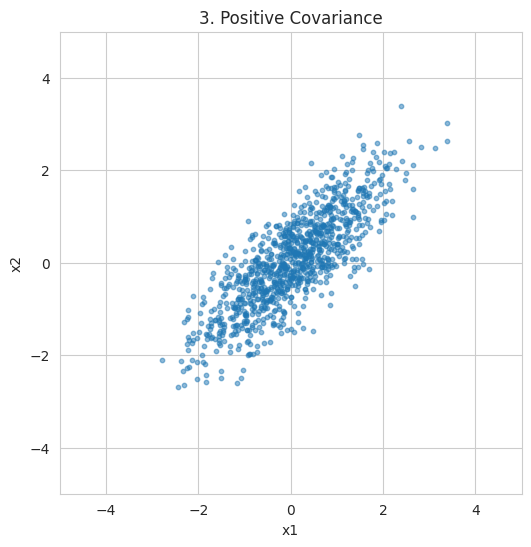

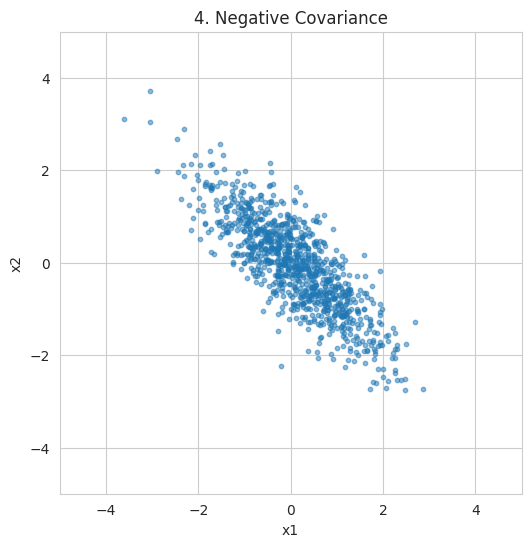

In [ ]:
# This code visualizes a 2D Gaussian distribution  and shows how its
# shape is controlled by the mean vector μ and the covariance matrix Σ.

import torch
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

def plot_mvg_samples(mean, cov, n_samples=1000, title=""):
    dist = torch.distributions.MultivariateNormal(mean, cov)
    samples = dist.sample((n_samples,))
    plt.figure(figsize=(6, 6))
    plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, s=10)
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

mean1 = torch.tensor([0.0, 0.0])
cov1 = torch.tensor([[1.0, 0.0],
                     [0.0, 1.0]])
plot_mvg_samples(mean1, cov1, title="1. Standard Normal")

mean2 = torch.tensor([0.0, 0.0])
cov2 = torch.tensor([[3.0, 0.0],
                     [0.0, 0.5]])
plot_mvg_samples(mean2, cov2, title="2. Diagonal Covariance")

mean3 = torch.tensor([0.0, 0.0])
cov3 = torch.tensor([[1.0, 0.8],
                     [0.8, 1.0]])
plot_mvg_samples(mean3, cov3, title="3. Positive Covariance")

mean4 = torch.tensor([0.0, 0.0])
cov4 = torch.tensor([[1.0, -0.8],
                     [-0.8, 1.0]])
plot_mvg_samples(mean4, cov4, title="4. Negative Covariance")

## Exercise 1:

Suppose you tried to define a covariance matrix cov = [[1, 2], [2, 1]] and run the code.
The torch.distributions.MultivariateNormal would raise an error. Why?

A) Covariance matrices cannot have values greater than 1.

B) The covariance matrix is not positive definite.

C) The covariance matrix must be symmetric, and this one is not.



In [ ]:
import torch

mean = torch.tensor([0.0, 0.0])
cov_invalid = torch.tensor([[1.0, 2.0],
                            [2.0, 1.0]])

try:
    dist = torch.distributions.MultivariateNormal(mean, cov_invalid)
    samples = dist.sample()
except Exception as e:
    print(f"error: {e}")

error: Expected parameter covariance_matrix (Tensor of shape (2, 2)) of distribution MultivariateNormal(loc: torch.Size([2]), covariance_matrix: torch.Size([2, 2])) to satisfy the constraint PositiveDefinite(), but found invalid values:
tensor([[1., 2.],
        [2., 1.]])


## Ans - Exercise 1:
### Option B
- the error appears that the matrix [[1,2],[2,1]] is not Positive Definite, because for the valid covariance matrix, it should be positive semidefinite.
- the determinant of the matrix gives one Eigen value to be negative, that makes it not positive definite.


## 1.1 Affine Transformation of a Gaussian

If `z ~ N(0, I)` is passed through an affine transform `x = Lz + μ`, then x is a Gaussian distribution with mean `μ` and Covariance `LL^T`.  This property is useful for sampling from a general (non-zero mean and non-identity covariance) Gaussian distribution. This also appears in the reparametrization trick in Variational Autoencoders (VAEs).

**How it helps in sampling:**

Any D-dimensional Gaussian random variable `x ~ N(μ, Σ)` can be generated by applying an affine transformation to a D-dimensional standard normal random variable `z ~ N(0, I)`.

The standard normal `z` is the base case:
*   Its mean is the zero vector: `E[z] = 0`.
*   Its covariance is the identity matrix: `Cov(z) = I`.

The affine transformation proposed is `x = Lz + μ`, where `L` is a `D x D` matrix and `μ` is a `D x 1` vector. The objective is to select `L` and `μ` such that the resulting random variable `x` has the desired mean `μ` and covariance `Σ`.

#### Derivation of the Transformation Parameters

We verify the properties of `x` using the properties of the expectation and covariance operators.

**A. Deriving the Mean of `x`**

The expectation `E[·]` is a linear operator. For a constant matrix `A` and constant vector `b`, `E[AZ + b] = A E[Z] + b`.

Applying this to our transformation:
$$
\begin{aligned}
E[x] &= E[Lz + \mu] \\
&= L \cdot E[z] + \mu
\end{aligned}
$$
Since `E[z] = 0` by definition of the standard normal, this simplifies to:
$$
E[x] = L \cdot 0 + \mu = \mu
$$
This confirms that the translation vector `μ` in the transformation correctly sets the mean of `x`.

**B. Deriving the Covariance of `x`**

The covariance matrix of a random vector `x` is defined as `Cov(x) = E[(x - E[x])(x - E[x])^T]`. For a constant matrix `A`, the covariance follows the rule `Cov(AZ) = A Cov(Z) A^T`.

Applying this to our transformation (specifically, to the `Lz` term, since `μ` is a constant and does not affect covariance):
$$
\begin{aligned}
Cov(x) &= Cov(Lz + \mu) \\
&= Cov(Lz) & \text{(Translation by a constant does not change covariance)} \\
&= L \cdot Cov(z) \cdot L^T
\end{aligned}
$$
By definition, `Cov(z) = I` (the identity matrix). Substituting this in:
$$
\begin{aligned}
Cov(x) &= L \cdot I \cdot L^T \\
&= L L^T
\end{aligned}
$$
This derivation establishes the central requirement: to generate samples `x` with a target covariance `Σ`, we must find a matrix `L` such that `L L^T = Σ`.

### Cholesky Decomposition

The problem is now reduced to finding a matrix `L` that satisfies the equation `Σ = LL^T` for a given covariance matrix `Σ`.

A covariance matrix `Σ` must be symmetric and positive semi-definite. For the non-degenerate case relevant here, it is strictly positive-definite. The **Cholesky decomposition** is a numerical algorithm that factorizes any symmetric, positive-definite matrix `A` into a product of a lower-triangular matrix `L` and its transpose `L^T`.
$$
A = LL^T
$$
where `L` has the form:
$$
L = \begin{pmatrix}
l_{11} & 0 & \dots & 0 \\
l_{21} & l_{22} & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
l_{D1} & l_{D2} & \dots & l_{DD}
\end{pmatrix}
$$


In [ ]:
def check_samples(samples, target_mean, target_cov):
    """
    Compares two sets of samples by their moments and returns the error norms.
    """
    mean_hat = samples.mean(dim=0)

    mean_error = torch.linalg.norm(mean_hat - target_mean)

    cov_hat = torch.cov(samples.T)

    cov_error = torch.linalg.norm(cov_hat - target_cov, ord='fro')

    print(f"Target Mean: {target_mean.numpy()}")
    print(f"Cholesky Sample Mean: {mean_hat.numpy()}")
    print(f"Error (Norm of difference) between Cholesky Mean and Target: {mean_error.item():.4f}\n")

    print(f"Target Covariance:\n{target_cov.numpy()}")
    print(f"Cholesky Sample Covariance:\n{cov_hat.numpy()}")
    print(f"Error (Frobenius norm) between Cholesky Cov and Target: {cov_error.item():.4f}\n")

    assert torch.abs(mean_error) < 0.1, "Mean error is not comparable"
    assert torch.abs(cov_error) < 0.1, "Covariance error is not comparable"

## Exercise 2:
Implement the cholesky decomposition method to sample from
a multivariate gaussian with a given mean (mean) and covariance (cov).

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

mean = torch.tensor([1.0, 2.0])
cov = torch.tensor([[2.0, 1.5],
                    [1.5, 2.0]])
n_samples = 50000

def cholesky_sampler(mean, cov, n_samples):
    L = torch.linalg.cholesky(cov)
    D = mean.shape[0]
    z = torch.randn(n_samples, D)
    samples = z @ L.T + mean
    return samples


samples = cholesky_sampler(mean=mean, cov=cov, n_samples=n_samples)
check_samples(samples, mean, cov)

Target Mean: [1. 2.]
Cholesky Sample Mean: [1.0004591 2.0069685]
Error (Norm of difference) between Cholesky Mean and Target: 0.0070

Target Covariance:
[[2.  1.5]
 [1.5 2. ]]
Cholesky Sample Covariance:
[[2.0134234 1.5124472]
 [1.5124472 2.0062823]]
Error (Frobenius norm) between Cholesky Cov and Target: 0.0230



## 1.2 Conditionals of Gaussians

Conditioning a joint Gaussian `p(x_a, x_b)` on an observation `x_b` yields a new Gaussian `p(x_a|x_b)` whose parameters are updated based on the original parameters and the value of the observation.

In machine learning, we often model the distribution of unobserved variables (e.g., model parameters `w`) and observed variables (e.g., data `D`) as Gaussian distribution. When both are modeled jointly as a Gaussian, inference becomes the act of computing the conditional distribution `p(w|D)`.



Let a D-dimensional random vector `x` be partitioned into two sub-vectors, `x_a` (M dimensions) and `x_b` (D-M dimensions). The joint distribution is a multivariate normal:
$$
p(x) = p(x_a, x_b) = N\left(x \mid \begin{pmatrix} \mu_a \\ \mu_b \end{pmatrix}, \begin{pmatrix} \Sigma_{aa} & \Sigma_{ab} \\ \Sigma_{ba} & \Sigma_{bb} \end{pmatrix}\right)
$$
Here, the mean vector `μ` and covariance matrix `Σ` are expressed as **block matrices**, which partition them according to the dimensions of `x_a` and `x_b`.

If we observe that `x_b` takes on a specific value, the conditional distribution `p(x_a | x_b)` is also a Gaussian. Its parameters are given by:
$$
\mu_{a|b} = \mu_a + \Sigma_{ab}\Sigma_{bb}^{-1}(x_b - \mu_b)
$$
$$
\Sigma_{a|b} = \Sigma_{aa} - \Sigma_{ab}\Sigma_{bb}^{-1}\Sigma_{ba}
$$


**Key Linear Algebra Concepts:**

1.  **Block Matrix:** A matrix that is partitioned into smaller sub-matrices called blocks. This is a notational convenience that simplifies operations on structured matrices, allowing us to reason about sub-vectors like `x_a` and `x_b` as single entities. All the terms above (`Σ_{aa}`, `Σ_{ab}`, etc.) are blocks of the full covariance matrix `Σ`.

2.  **Matrix Inverse of a Block Matrix:** The derivation of these formulas relies on the rules for inverting a block matrix. Specifically, the conditional covariance `Σ_{a|b}` is the inverse of the `Λ_{aa}` block of the precision matrix `Λ = Σ⁻¹`.

3.  **Schur Complement:** The expression for the conditional covariance, $Σ_{a|b} = \Sigma_{aa} - \Sigma_{ab}\Sigma_{bb}^{-1}\Sigma_{ba}$, is known as the **Schur complement** of the block `Σ_{bb}` in the matrix `Σ`. This object arises naturally in various contexts in machine learning. Here, it represents the residual uncertainty in `x_a` after the information from `x_b` has been accounted for. The fact that $Σ_{ab}\Sigma_{bb}^{-1}\Sigma_{ba}$ is positive semi-definite guarantees that conditioning reduces (or at best, maintains) variance.



## Exercise 3:

Your task is to implement and visualize this conditioning process for a simple 2D case.

1. Define a 2D joint Gaussian `p(x1, x2)` with a non-diagonal covariance, representing the prior belief over `x1` and `x2`.
2.  Assume you observe that `x2` has a specific value, for example, `x2 = 2.0`.
3. Partition your 2x2 covariance matrix `Σ` and 2x1 mean vector `μ` into their scalar components (`Σ_11`, `Σ_12`, `Σ_22`, `μ_1`, `μ_2`), treating `x_a` as `x1` and `x_b` as `x2`.
4.  Implement the general formulas using these scalar/matrix components to calculate the conditional mean `μ_{1|2}` and conditional covariance (which is just a variance in 1D) `Σ_{1|2}`.


It might be also useful to visualize the result. One way to do this is as follows:
Create a plot that shows the contour plot of the original 2D joint distribution. Plot a horizontal line indicating the observation `x2 = 2.0`. Finally, the resulting 1D conditional Gaussian `p(x1 | x2 = 2.0)` can be plotted along that horizontal line, clearly showing its new mean and reduced variance.


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm

joint_mean = torch.tensor([0.0, 1.0])
joint_cov = torch.tensor([[1.0, 0.9],
                          [0.9, 1.0]])
dist = torch.distributions.MultivariateNormal(joint_mean, joint_cov)

x_b_observed = torch.tensor([2.0])


def return_conditional_gaussian(joint_mean, joint_cov, x_b_observed):

  mu1 = joint_mean[0]
  mu2 = joint_mean[1]

  s11 = joint_cov[0, 0]
  s22 = joint_cov[1, 1]
  s12 = joint_cov[0, 1]

  x2 = x_b_observed.squeeze()

  inv_s22 = 1.0 / s22
  mu_cond = mu1 + s12 * inv_s22 * (x2 - mu2)
  var_cond = s11 - s12 * inv_s22 * s12

  return mu_cond, var_cond


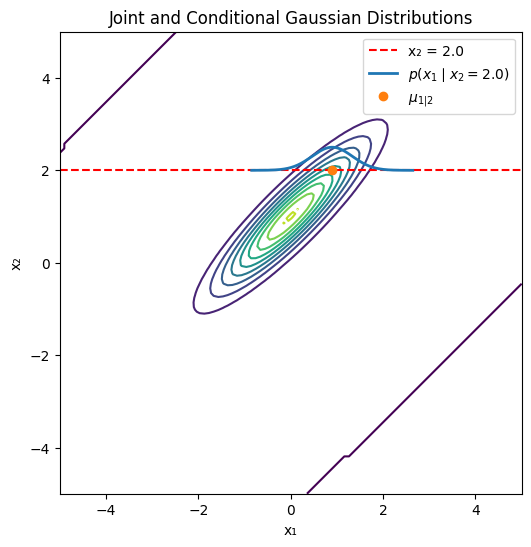

In [ ]:
mu_cond, var_cond = return_conditional_gaussian(joint_mean, joint_cov, x_b_observed)
std_cond = torch.sqrt(var_cond)
obs_x2 = float(x_b_observed)

x1_vals = np.linspace(-5, 5, 100)
x2_vals = np.linspace(-5, 5, 100)
X1, X2 = np.meshgrid(x1_vals, x2_vals)
pos = np.empty(X1.shape + (2,))
pos[..., 0] = X1
pos[..., 1] = X2

rv = torch.distributions.MultivariateNormal(joint_mean, joint_cov)
Z = torch.exp(rv.log_prob(torch.tensor(pos, dtype=torch.float32))).numpy()

plt.figure(figsize=(7, 6))
plt.contour(X1, X2, Z, levels=10)

plt.axhline(obs_x2, color='red', linestyle='--', label=f'x₂ = {obs_x2}')

xs = np.linspace(float(mu_cond - 4*std_cond), float(mu_cond + 4*std_cond), 400)
pdf = norm.pdf(xs, loc=float(mu_cond), scale=float(std_cond))
scale = 0.5 / pdf.max()
plt.plot(xs, obs_x2 + scale * pdf, linewidth=2, label=r'$p(x_1 \mid x_2=2.0)$')

plt.plot([float(mu_cond)], [obs_x2], 'o', label=r'$\mu_{1|2}$')

plt.xlabel('x₁'); plt.ylabel('x₂')
plt.legend()
plt.title("Joint and Conditional Gaussian Distributions")
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# II. Linear Regression and Probabilistic Modeling [50 points]

In this section, your task is to build a probabilistic linear regression model  for concrete strength prediction. As mentioned in class lectures, this is an important problem with downstream implications for designing sustainable concrete. For more information, please see this paper [Paper link](https://arxiv.org/pdf/2310.18288).

You will work with a concrete strength dataset (please see link below) containing 8 input features ($\mathbf{x}$) that characterize different concrete mixture compositions. The target variable($y$) is **strength** (compressive strength of the mixture).

[Concrete Strength Dataset Link](https://drive.google.com/file/d/15UaTJ9ga8uvdoqmRCghIPxJ3bqTveAnt/view?usp=sharing)


## Exercise 4. Create a Bayesian Linear Regression (BLR) model for the concrete strength dataset.

Your deliverable should be python code that satisfies following requirements:

The model should be implemented as a class named BayesianLinearRegression which we can instantiate as `model = BayesianLinearRegression()`.  The class should implement following two methods:
- `fit(X, y)` which takes as input two numpy arrays corresponding to X: inputs  of shape (n_samples, n_features=8) and y: outputs of shape (n_samples,) and trains the model. As we discussed, in BLR, training a model corresponds to computing the posterior over weights. The function should return both posterior mean and posterior variance weights as numpy arrays.
- `predict(X)` which takes as input one numpy array X of shape (n_test_samples, n_features=8)  andreturns a mean and variance prediction over the inputs. In BLR, this corresponds to computing the posterior predictive distribution over the inputs.

----
We will use k-fold cross validation with standard regression metrics (R2 (coefficient of determination), RMSE (Root Mean Squared Error),  MAE(Mean Absolute Error)) to evaluate your code. scikit-learn provide implementation for
all these metrics `from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error` [sklearn metrics link](https://scikit-learn.org/stable/modules/model_evaluation.html).

----
Next cell provides an example template for this code. Please feel free to use your own style if preferred but it should satisfy all the above requirements.

In [ ]:
!pip install gdown

In [ ]:
# DATA ANALYSIS

import pandas as pd
import numpy as np
import gdown
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler

file_id = "15UaTJ9ga8uvdoqmRCghIPxJ3bqTveAnt"
url = f"https://drive.google.com/uc?id={file_id}"
output = "concrete_strength_data.csv"
gdown.download(url, output, quiet=False)

data = pd.read_csv(output)

# Data check
print(data.head())
print(data.info())
print(data.describe())

# Separate features and target
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Check for NaNs
print(np.isnan(X).sum(), np.isnan(y).sum())

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Downloading...
From: https://drive.google.com/uc?id=15UaTJ9ga8uvdoqmRCghIPxJ3bqTveAnt
To: /content/concrete_strength_data.csv
100%|██████████| 14.2k/14.2k [00:00<00:00, 9.02MB/s]


   Cement  Fly Ash    Slag  Water  HRWR  Fine Aggregate  Curing Temp (Cel.)  \
0  353.33    46.67  266.67  140.0  6.67          1833.0                22.0   
1  353.33    46.67  266.67  140.0  6.67          1833.0                22.0   
2  353.33    46.67  266.67  140.0  6.67          1833.0                22.0   
3  353.33    46.67  266.67  140.0  6.67          1833.0                22.0   
4  214.67   220.00  232.00  159.0  4.00          1833.0                22.0   

   Time  strength  
0   1.0    5000.0  
1   3.0    7235.0  
2   5.0    7318.0  
3  28.0   10290.0  
4   1.0    3440.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Cement              270 non-null    float64
 1   Fly Ash             270 non-null    float64
 2   Slag                270 non-null    float64
 3   Water               270 non-null    float64
 4   HR

In [ ]:
# LINEAR REGRESSION

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


kf = KFold(n_splits=5, shuffle=True, random_state=42)

r2s, rmses, maes = [], [], []
y_true_all, y_pred_all = [], []

model = None

for fold, (tr, te) in enumerate(kf.split(X, y), start=1):
    X_train_fold, X_val_fold = X[tr], X[te]
    y_train_fold, y_val_fold = y[tr], y[te]

    pipe = make_pipeline(StandardScaler(), LinearRegression())
    pipe.fit(X_train_fold, y_train_fold)

    y_pred_fold = pipe.predict(X_val_fold)
    y_true_fold = y_val_fold

    r2s.append(r2_score(y_true_fold, y_pred_fold))
    rmses.append(np.sqrt(mean_squared_error(y_true_fold, y_pred_fold)))
    maes.append(mean_absolute_error(y_true_fold, y_pred_fold))

    y_true_all.append(y_true_fold)
    y_pred_all.append(y_pred_fold)
    model = pipe

print(f"Linear Regression (5-fold CV on entire dataset):")
print(f"Mean R2   : {np.mean(r2s):.4f} ± {np.std(r2s):.4f}")
print(f"Mean RMSE : {np.mean(rmses):.4f} ± {np.std(rmses):.4f}")
print(f"Mean MAE  : {np.mean(maes):.4f} ± {np.std(maes):.4f}")

y_true_cv = np.concatenate(y_true_all)
y_pred_cv = np.concatenate(y_pred_all)

Linear Regression (5-fold CV on training data):
Mean R2   : 0.6797 ± 0.0851
Mean RMSE : 1560.1387 ± 227.7240
Mean MAE  : 1225.9168 ± 197.1203

Linear Regression (Evaluation on test set):
R2   : 0.6692
RMSE : 1658.8727
MAE  : 1323.6817



Bayesian Linear Regression Performance:
R2:   0.6634
RMSE: 1598.4014
MAE:  1256.9725


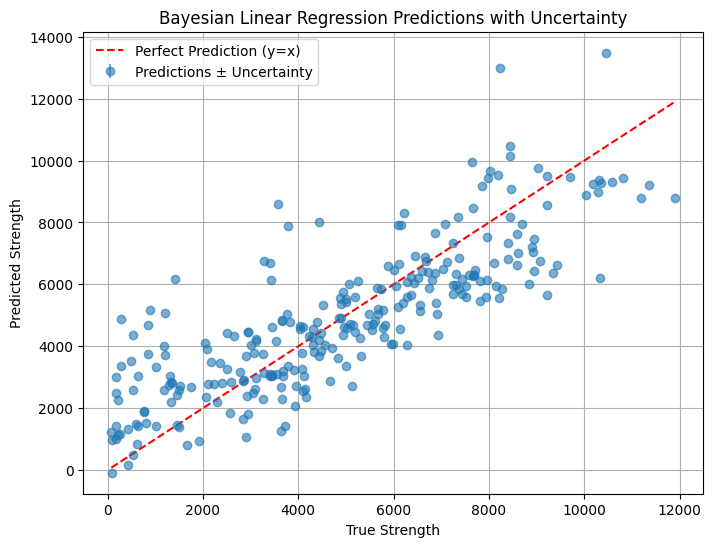

In [ ]:
### BAYESIAN LINEAR REGRESSION

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler

class BayesianLinearRegression:
    """
    Bayesian Linear Regression following Bishop's PRML Notation.

    Mathematical Model:
    - Prior over weights: p(w) = N(w | 0, alpha^{-1} * I)
    - Likelihood: p(y | X, w, beta) = N(y | X*w, beta^{-1} * I)
    - Posterior over weights: p(w | X, y) = N(w | m_N, S_N)

    Key Formulas:
    - Posterior covariance: S_N = (alpha*I + beta*X^T*X)^{-1}
    - Posterior mean: m_N = beta * S_N * X^T * y
    - Predictive mean: y_* = x_*^T * m_N
    - Predictive variance: var_* = beta^{-1} + x_*^T * S_N * x_*
    """

    def __init__(self, alpha=1.0, beta=1.0, fit_intercept=True):
        """
        Initialize Bayesian Linear Regression.

        Hyperparameter Selection Guide:
        --------------------------------

        Alpha (Prior Precision):
        - Controls regularization strength on weights
        - Higher alpha = stronger regularization = smaller weights
        - Typical range: 0.01 to 100
        - Start with alpha=1.0

        Beta (Noise Precision):
        - Controls assumed noise level in observations
        - Higher beta = less noise assumed
        - Start with beta in range 1.0 to 3.0 for this dataset
        - Can also estimate it from data: beta ≈ 1/var(residuals) from initial fit

        Parameters:
        -----------
        alpha : float, default=1.0

        beta : float, default=1.0
        """
        self.alpha = alpha
        self.beta = beta
        self.fit_intercept = fit_intercept
        self.m_N = None
        self.S_N = None


    def _design_matrix(self, X):
        """Add intercept column if fit_intercept=True"""
        if self.fit_intercept:
            ones = np.ones((X.shape[0], 1))
            return np.hstack([ones, X])
        return X


    def fit(self, X, y):
        """
        Compute posterior distribution over weights given training data.

        Mathematical Steps:
        1. Create design matrix Φ from input X. In this case, it is just X itself.
        The only extra step is to add a column of ones to the left of X if you are
        also fitting a separate bias term.
        2. Set up prior: mean=0, covariance=(1/alpha)*I
        3. Compute posterior covariance: S_N = (alpha*I + beta*Φ^T*Φ)^{-1}
        4. Compute posterior mean: m_N = beta * S_N * Φ^T * y


        Numerical Stability Tips:
        ------------------------
        - Use np.linalg.solve(A, rhs) instead of np.linalg.inv(A) @ rhs when possible
        - Check condition number of A before inversion

        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Training input features
        y : array-like, shape (n_samples,)
            Training target values

        Returns:
        --------
        m_N : numpy array, shape (n_features,)
            Posterior mean of weights
        S_N : numpy array, shape (n_features, n_features)
            Posterior covariance of weights
        """

        X = np.asarray(X)
        y = np.asarray(y).flatten()
        Phi = self._design_matrix(X)
        n_features = Phi.shape[1]
        A = self.alpha * np.eye(n_features) + self.beta * (Phi.T @ Phi)
        self.S_N = np.linalg.inv(A)
        self.m_N = self.beta * np.linalg.solve(A, Phi.T) @ y

        return self.m_N, self.S_N


    def predict(self, X, return_std=False):
        """
        Make predictions using posterior predictive distribution.

        Mathematical Steps:
        1. For each test point x_*:
           - Predictive mean: μ_* = x_*^T * m_N
           - Predictive variance: σ²_* = (1/beta) + x_*^T * S_N * x_*

        Implementation Steps:
        --------------------
        1. Check if model has been fitted (posterior parameters exist)
        2. Create design matrix for test inputs. In this case, it is just X itself.
        The only extra step is to add a column of ones to the left of X if you are
        also fitting a separate bias term. Keep it consistent with the training step.
        3. Compute predictive means: Φ_test @ m_N
        5. Return predictive distribution's mean and variance

        Parameters:
        -----------
        X : array-like, shape (n_test_samples, n_features)
            Test input features

        Returns:
        --------
        y_mean : array, shape (n_test_samples,)
            Predictive means
        y_var : array, shape (n_test_samples,)
            Predictive variances
        """
        if self.m_N is None or self.S_N is None:
            raise RuntimeError("Model not fitted yet")
        Phi_test = self._design_matrix(np.asarray(X))
        y_mean = Phi_test @ self.m_N
        y_var = 1.0 / self.beta + np.sum(Phi_test @ self.S_N * Phi_test, axis=1)

        if return_std:
            return y_mean, np.sqrt(y_var)
        return y_mean, y_var


def plot_fold_predictions(y_true, y_pred, y_std, fold_num):
  ## Used the help of AI for this plotting function
  plt.figure(figsize=(8, 6))
  plt.scatter(y_true, y_pred, s=10, alpha=0.7, label="Predicted Mean")
  plt.errorbar(y_true, y_pred, yerr=y_std, fmt='none', alpha=0.25, label="±1 Standard Deviation")
  lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
  plt.plot(lims, lims, linestyle='--', color='red', label="Perfect Prediction (y=x)")
  plt.xlabel("True strength (y)")
  plt.ylabel("Predicted mean (ŷ)")
  plt.title(f"BLR Predictions with (Fold {fold_num})")
  plt.legend()
  plt.grid(alpha=0.3)
  plt.show()


kf = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores_cv, rmse_scores_cv, mae_scores_cv = [], [], []
all_y_true, all_y_pred, all_y_std = [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X), start=1):
    X_train_fold, X_val_fold = X[train_idx], X[test_idx]
    y_train_fold, y_val_fold = y[train_idx], y[test_idx]

    #Scaling
    scaler = StandardScaler()
    X_train_fold_scaled = scaler.fit_transform(X_train_fold)
    X_val_fold_scaled = scaler.transform(X_val_fold)

    #Bayesian Linear Regression Model
    model = BayesianLinearRegression(alpha=1.0, beta=1.0, fit_intercept=True)
    model.fit(X_train_fold_scaled, y_train_fold)
    y_pred_fold, y_std_fold = model.predict(X_val_fold_scaled, return_std=True)

    #Evaluation metrics
    r2_fold = r2_score(y_val_fold, y_pred_fold)
    rmse_fold = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
    mae_fold = mean_absolute_error(y_val_fold, y_pred_fold)
    print(f"Fold {fold} Metrics")
    print(f"R2   : {r2_fold:.4f}")
    print(f"RMSE : {rmse_fold:.4f}")
    print(f"MAE  : {mae_fold:.4f}")

    r2_scores_cv.append(r2_fold)
    rmse_scores_cv.append(rmse_fold)
    mae_scores_cv.append(mae_fold)

    plot_fold_predictions(y_val_fold, y_pred_fold, y_std_fold, fold)


print("\nBayesian Linear Regression average metrics:")
print(f"Mean R2   : {np.mean(r2_scores_cv):.4f} ± {np.std(r2_scores_cv):.4f}")
print(f"Mean RMSE : {np.mean(rmse_scores_cv):.4f} ± {np.std(rmse_scores_cv):.4f}")
print(f"Mean MAE  : {np.mean(mae_scores_cv):.4f} ± {np.std(mae_scores_cv):.4f}")


In [ ]:
# HYPERPARAMETER TUNING

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt


#hyperparameter grid
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
    'beta': [1.0, 2.0, 3.0],
    'fit_intercept': [True, False]
}

X_np = np.asarray(X)
y_np = np.asarray(y).flatten()

kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_r2 = -float('inf')
best_params = None
results = []

print("Starting Grid Search with Cross-Validation...")

for alpha in param_grid['alpha']:
    for beta in param_grid['beta']:
        for fit_intercept in param_grid['fit_intercept']:
            fold_r2s = []
            print(f"Evaluating alpha={alpha}, beta={beta}, fit_intercept={fit_intercept}")

            #K-Fold Cross-Validation
            for fold, (train_idx, test_idx) in enumerate(kf.split(X_np), start=1):
                X_train_fold, X_val_fold = X_np[train_idx], X_np[test_idx]
                y_train_fold, y_val_fold = y_np[train_idx], y_np[test_idx]

                # Scaling
                scaler = StandardScaler()
                X_train_fold_scaled = scaler.fit_transform(X_train_fold)
                X_val_fold_scaled = scaler.transform(X_val_fold)

                #Bayesian Linear Regression model
                model = BayesianLinearRegression(alpha=alpha, beta=beta, fit_intercept=fit_intercept) # Pass fit_intercept
                model.fit(X_train_fold_scaled, y_train_fold)

                y_pred_fold, _ = model.predict(X_val_fold_scaled, return_std=False)
                r2_fold = r2_score(y_val_fold, y_pred_fold)
                fold_r2s.append(r2_fold)

            mean_r2 = np.mean(fold_r2s)
            results.append({'alpha': alpha, 'beta': beta, 'fit_intercept': fit_intercept, 'mean_r2': mean_r2}) # Store all params and mean_r2

            print(f"  Average R2: {mean_r2:.4f}")

            # Update best parameters
            if mean_r2 > best_r2:
                best_r2 = mean_r2
                best_params = {'alpha': alpha, 'beta': beta, 'fit_intercept': fit_intercept} # Store all best params


print("\nGrid Search Finished.")
print(f"Best R2 found: {best_r2:.4f}")
print(f"Best hyperparameters: {best_params}")

Bayesian Linear Regression (5-fold CV on training data):
Mean R2   : 0.6801 ± 0.0836
Mean RMSE : 1560.2508 ± 225.8016
Mean MAE  : 1230.7885 ± 195.2648

Bayesian Linear Regression (Evaluation on held-out test set):
R2   : 0.6688
RMSE : 1659.7620
MAE  : 1342.7228


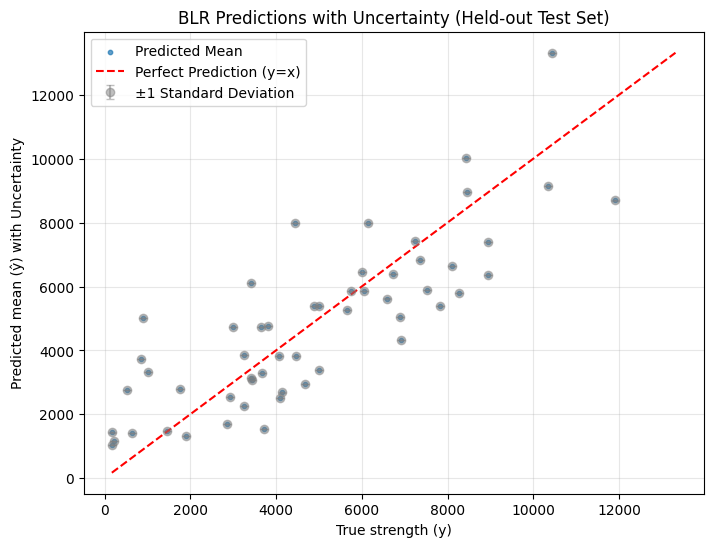

In [ ]:
## Final Model: BAYESIAN LINEAR

# Scaling
scaler_final = StandardScaler()
X_scaled = scaler_final.fit_transform(X)

# final BLR model with selected hyper parameters
final_model = BayesianLinearRegression(alpha=1.0, beta=1.0, fit_intercept=True)
final_model.fit(X_scaled, y)

y_pred_final, y_std_final = final_model.predict(X_scaled, return_std=True)

r2_final = r2_score(y, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y, y_pred_final))
mae_final = mean_absolute_error(y, y_pred_final)

print("\nFinal Model Trained on Full Dataset:")
print(f"R2   : {r2_final:.4f}")
print(f"RMSE : {rmse_final:.4f}")
print(f"MAE  : {mae_final:.4f}")


# Bayesian Decision Theory [25 points]

Now imagine if you want to create a new concrete mixture ($\mathbf{x}$) that achieves maximum possible strength. Each experimental trial involves mixing, curing, and testing concrete which is expensive and time-consuming. Your goal is to find the optimal mixture composition using as few experiments as possible.  One way to tackle this problem is by iteratively picking good mixture candidates guided by our model. Given your prior observations and probabilistic model that provides both mean and uncertainty estimates, you want to decide which mixture ($\mathbf{x}$) to pick next? We can use decision theory to solve this problem. This section builds up one exercise at a time to address this question.

**Decision Problem Formulation**

We seek to find the maximum of an expensive-to-evaluate black-box function $f(\mathbf{x})$:

-   **Objective:** $f(\mathbf{x}) \rightarrow \mathbb{R}$ represents our unknown objective function (e.g., compressive strength as a function of mixture proportions).
-   **Data:** We have $n$ observations $D = \{(\mathbf{x}_1, y_1), ..., (\mathbf{x}_n, y_n)\}$ where $y_i = f(\mathbf{x}_i)$. For example, the dataset you used in previous section.
-   **Model:** We use a probabilistic model (e.g., Bayesian Linear Regression) that provides a posterior predictive distribution $p(f(\mathbf{x})|D)$ for any candidate point $\mathbf{x}$.
-   **Assumption:** The posterior predictive distribution is Gaussian: $p(f(\mathbf{x})|D) = N(\mu(\mathbf{x}), \sigma^2(\mathbf{x}))$.

Our decision problem: Which point $\mathbf{x}$ should we evaluate next to most efficiently locate the global maximum?

## Exercise 5: Posterior Beliefs About the Objective

Before making decisions, we must understand what our probabilistic model tells us about unobserved function values.

Consider a candidate point $\mathbf{x}$ that we have not yet evaluated. Our Bayesian model has been trained on the dataset $D$.

**Question:** According to our Bayesian model, what do we "know" about the value $f(\mathbf{x})$ at this unevaluated point?

a) The model predicts a single, definitive value for $f(\mathbf{x})$, which is $\mu(\mathbf{x})$.

b) The model represents $f(\mathbf{x})$ as a random variable with probability distribution $N(\mu(\mathbf{x}), \sigma^2(\mathbf{x}))$.

c) The model only quantifies uncertainty $\sigma(\mathbf{x})$ about the function's value, but provides no information about its most likely value.

d) The model provides the true, noise-free value of $f(\mathbf{x})$

##5. Answer: Option B

Option B is the correct answer the bayesian model provides the output with a dsitribution that has mean and variance. The mean that is predicted gives the most likely value, and also a variance which will give the uncertainty about the prediction. The model takes care of both epistemic and aleatoric uncertainty.

## Exercise 6: Defining the Utility Function

To decision which point x to pick next, we need a utility function that quantifies the value of different outcomes. In maximization, we care about **improvement** over our current best solution.

Let $y^* = \max\{y_1, y_2, ..., y_n\}$ be the best function value observed so far in our dataset.

We define an **Improvement function** $I(f(\mathbf{x}))$ that measures how much better $f(\mathbf{x})$ is compared to our current best $y^*$. This **Improvement function** is our utility function.

**Question:** What is a sensible and mathematically correct definition for the Improvement function $I(f(\mathbf{x}))$?

a) $I(f(\mathbf{x})) = f(\mathbf{x}) - y^*$

b) $I(f(\mathbf{x})) = |f(\mathbf{x}) - y^*|$

c) $I(f(\mathbf{x})) = \max(0, f(\mathbf{x}) - y^*)$

d) $I(f(\mathbf{x})) = (f(\mathbf{x}) - y^*)^2$

## 6. Answer: Option C

option c makes most sense to have as the Improvement function. This is because it correctly quantifies how much better the new value is compared to the current best, or 0 if it is worse. In other options such as b and d, even if f(x) is worse, it will be penalised as we wouldn't know if it was worse as the result become positive. in option A, the improvement function can be negative as well. thereforse option c is the best one.


## Exercise 7: Expected Utility Framework


The principle of decision theory tells us to choose the action $x$ that maximizes the *expected* utility. Here, our utility is the Improvement $I(f(\mathbf{x}))$.  Since $f(\mathbf{x})$ is a random variable according to our model, the improvement $I(f(\mathbf{x}))$ is also random.

The **Expected Improvement (EI)** at point $\mathbf{x}$ is the expected value of our utility function: $\text{EI}(\mathbf{x}) = \mathbb{E}[I(f(\mathbf{x})) | D]$.

**Question:** Which integral correctly expresses the Expected Improvement?

a) $\text{EI}(\mathbf{x}) = \int_{-\infty}^{\infty} \max(0, y - y^*) \cdot \mu(\mathbf{x}) \,dy$

b) $\text{EI}(\mathbf{x}) = \int_{-\infty}^{\infty} \max(0, y - y^*) \cdot N(y | \mu(\mathbf{x}), \sigma^2(\mathbf{x})) \,dy$

c) $\text{EI}(\mathbf{x}) = \int_{-\infty}^{\infty} (y - y^*) \cdot N(y | \mu(\mathbf{x}), \sigma^2(\mathbf{x})) \,dy$

d) $\text{EI}(\mathbf{x}) = \max(0, \mu(\mathbf{x}) - y^*)$

## 7. Ans: Option B

Since f(x) is a random variable it is modeled also as a random variable with mean mu and variance sigma square. And as we want to find the expected improvement we need to find the integral of Improvement function that is max(0,f(x)-y*). therefore the right answer is option B.

##

### Final Expected Improvement Expression

After solving the integral in Exercise 7, Expected Improvement can be computed in closed analytic form as:
$$\text{EI}(\mathbf{x}) = (\mu(\mathbf{x}) - y^*) \Phi(Z) + \sigma(\mathbf{x}) \phi(Z)$$
where $Z = \frac{\mu(\mathbf{x}) - y^*}{\sigma(\mathbf{x})}$, $\Phi(z)$ is the standard normal CDF, and $\phi(z)$ is the standard normal PDF.

### Interpretation of Expected Improvement

Let's interpret this final formula: $\text{EI}(\mathbf{x}) = (\mu(\mathbf{x}) - y^*) \Phi(Z) + \sigma(\mathbf{x}) \phi(Z)$

-   **Term 1: $(\mu(\mathbf{x}) - y^*) \Phi(Z)$ (Exploitation):** The term $(\mu(\mathbf{x}) - y^*)$ is large when our model predicts a high mean value, far above the current best. This encourages us to query points that are expected to be good. This is the **exploitation** component.

-   **Term 2: $\sigma(\mathbf{x}) \phi(Z)$ (Exploration):** This term is scaled by $\sigma(\mathbf{x})$, our uncertainty. It is large when the uncertainty about $f(\mathbf{x})$ is high. This encourages us to query points in regions we know little about, even if their mean prediction $\mu(\mathbf{x})$ is not the highest. This is the **exploration** component.

### Connection to Bayesian Optimization

You just derived, from first principles, an instance of a  foundational method in modern machine learning. The entire process you've worked through is a framework known as [Bayesian Optimization (BO)](https://www.cs.ox.ac.uk/people/nando.defreitas/publications/BayesOptLoop.pdf). The problem of optimizing expensive, black-box functions is the exact problem BO is designed to solve.

-   Your probabilistic model is called a **Surrogate Model** in the BO literature.
-   The decision-making criterion you derived, $\text{EI}(\mathbf{x})$, is a popular **Acquisition Function**.

The overall BO algorithm is a simple and powerful loop:

1.  For all candidate points $\mathbf{x}$, calculate the value of the acquisition function (in this case, Expected Improvement).
2.  Choose the point $\mathbf{x}_{\text{next}}$ that maximizes the acquisition function: $\mathbf{x}_{\text{next}} = \arg\max_{\mathbf{x}} \text{EI}(\mathbf{x})$.
3.  Perform the expensive experiment at $\mathbf{x}_{\text{next}}$ to get the true result $y_{\text{next}}$.
4.  Add $(\mathbf{x}_{\text{next}}, y_{\text{next}})$ to your dataset and update the surrogate model.
5.  Repeat until your budget of experiments is exhausted. experiments is exhausted.

BO is used in a large number of applications. Please see the appendix section titled *ANNOTATED BIBLIOGRAPHY OF APPLICATIONS* in this bayesopt book. [Book Link](https://bayesoptbook.com/book/bayesoptbook.pdf)